In [1]:
# sedona and pyspark imports
from sedona.spark import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType

In [2]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import geopandas as gpd
import pandas as pd
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from shapely.geometry import Point
from shapely.geometry import Polygon

from sedona.spark import *
from sedona.core.geom.envelope import Envelope

In [3]:
config = (
    SedonaContext.builder()
    .config(
        "spark.jars.packages",
        "org.apache.sedona:sedona-spark-3.3_2.12:1.7.1,"
        "org.datasyslab:geotools-wrapper:1.7.1-28.5",
    )
    .config(
        "spark.jars.repositories",
        "https://artifacts.unidata.ucar.edu/repository/unidata-all",
    )
    .getOrCreate()
)
sedona = SedonaContext.create(config)

https://artifacts.unidata.ucar.edu/repository/unidata-all added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/cdsw/.ivy2/cache
The jars for the packages stored in: /home/cdsw/.ivy2/jars
org.apache.sedona#sedona-spark-3.3_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d401e522-090e-46e9-9a30-b199d1750832;1.0
	confs: [default]


:: loading settings :: url = jar:file:/runtime-addons/spark330-22-p3v4jn/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.sedona#sedona-spark-3.3_2.12;1.7.1 in central
	found org.apache.sedona#sedona-common;1.7.1 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found org.locationtech.jts#jts-core;1.20.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.locationtech.spatial4j#spatial4j;0.8 in central
	found com.google.geometry#s2-geometry;2.0.0 in central
	found com.google.guava#guava;25.1-jre in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found org.checkerframework#checker-qual;2.0.0 in central
	found com.google.errorprone#error_prone_annotations;2.1.3 in central
	found com.google.j2objc#j2objc-annotations;1.1 in central
	found org.codehaus.mojo#animal-sniffer-annotations;1.14 in central
	found com.uber#h3;4.1.1 in central
	found net.sf.geographiclib#GeographicLib-Java;1.52 in central
	found com.github.ben-manes.caffeine#caffeine;2.9.2 in central
	found org.checkerframework#checker-qual;3.10.0 in central
	found com.google.error

In [4]:
sc = sedona.sparkContext

# Create SpatialRDD

## Reading to PointRDD from CSV file

Suppose we want load the CSV file into Apache Sedona PointRDD
```
testattribute0,-88.331492,32.324142,testattribute1,testattribute2
testattribute0,-88.175933,32.360763,testattribute1,testattribute2
testattribute0,-88.388954,32.357073,testattribute1,testattribute2
testattribute0,-88.221102,32.35078,testattribute1,testattribute2
testattribute0,-88.323995,32.950671,testattribute1,testattribute2
testattribute0,-88.231077,32.700812,testattribute1,testattribute2
```

In [5]:
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, True, 10)

In [6]:
## Getting approximate total count
point_rdd.approximateTotalCount

3000

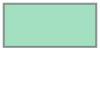

In [7]:
# getting boundary for PointRDD or any other SpatialRDD, it returns Envelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundary()

In [8]:
# To run analyze please use function analyze
point_rdd.analyze()

True

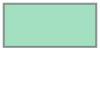

In [9]:
# Finding boundary envelope for PointRDD or any other SpatialRDD, it returns Envelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundaryEnvelope

In [10]:
# Calculate number of records without duplicates
point_rdd.countWithoutDuplicates()

2996

In [11]:
# Getting source epsg code
point_rdd.getSourceEpsgCode()

''

In [12]:
# Getting target epsg code
point_rdd.getTargetEpsgCode()

''

In [13]:
# Spatial partitioning data
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

## Operations on RawSpatialRDD

rawSpatialRDD method returns RDD which consists of GeoData objects which has 2 attributes
<li> geom: shapely.geometry.BaseGeometry </li>
<li> userData: str </li>

You can use any operations on those objects and spread across machines

In [14]:
# take firs element
point_rdd.rawSpatialRDD.take(1)

[Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [15]:
# collect to Python list
point_rdd.rawSpatialRDD.collect()[:5]

[Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [16]:
# apply map functions, for example distance to Point(52 21)
point_rdd.rawSpatialRDD.map(lambda x: x.geom.distance(Point(21, 52))).take(5)

[111.08786851399313,
 110.92828303170774,
 111.1385974283527,
 110.97450594034112,
 110.97122518072091]

## Transforming to GeoPandas

## Loaded data can be transformed to GeoPandas DataFrame in a few ways

### Directly from RDD

In [17]:
point_rdd_to_geo = point_rdd.rawSpatialRDD.map(
    lambda x: [x.geom, *x.getUserData().split("\t")]
)

In [18]:
point_gdf = gpd.GeoDataFrame(
    point_rdd_to_geo.collect(),
    columns=["geom", "attr1", "attr2", "attr3"],
    geometry="geom",
)

In [19]:
point_gdf[:5]

,geom,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.2211 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.324 32.95067),testattribute0,testattribute1,testattribute2


### Using Adapter

In [20]:
# Adapter allows you to convert geospatial data types introduced with sedona to other ones

In [21]:
spatial_df = Adapter.toDf(
    point_rdd, ["attr1", "attr2", "attr3"], sedona
).createOrReplaceTempView("spatial_df")

spatial_gdf = sedona.sql("Select attr1, attr2, attr3, geometry as geom from spatial_df")

In [22]:
spatial_gdf.show(5, False)

+--------------+--------------+--------------+----------------------------+
|attr1         |attr2         |attr3         |geom                        |
+--------------+--------------+--------------+----------------------------+
|testattribute0|testattribute1|testattribute2|POINT (-88.331492 32.324142)|
|testattribute0|testattribute1|testattribute2|POINT (-88.175933 32.360763)|
|testattribute0|testattribute1|testattribute2|POINT (-88.388954 32.357073)|
|testattribute0|testattribute1|testattribute2|POINT (-88.221102 32.35078) |
|testattribute0|testattribute1|testattribute2|POINT (-88.323995 32.950671)|
+--------------+--------------+--------------+----------------------------+
only showing top 5 rows



In [23]:
gpd.GeoDataFrame(spatial_gdf.toPandas(), geometry="geom")[:5]

,attr1,attr2,attr3,geom
0,testattribute0,testattribute1,testattribute2,POINT (-88.33149 32.32414)
1,testattribute0,testattribute1,testattribute2,POINT (-88.17593 32.36076)
2,testattribute0,testattribute1,testattribute2,POINT (-88.38895 32.35707)
3,testattribute0,testattribute1,testattribute2,POINT (-88.2211 32.35078)
4,testattribute0,testattribute1,testattribute2,POINT (-88.324 32.95067)


### With DataFrame creation

In [24]:
schema = StructType(
    [
        StructField("geometry", GeometryType(), False),
        StructField("attr1", StringType(), False),
        StructField("attr2", StringType(), False),
        StructField("attr3", StringType(), False),
    ]
)

In [25]:
geo_df = sedona.createDataFrame(point_rdd_to_geo, schema, verifySchema=False)

In [26]:
gpd.GeoDataFrame(geo_df.toPandas(), geometry="geometry")[:5]

,geometry,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.2211 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.324 32.95067),testattribute0,testattribute1,testattribute2


# Load Typed SpatialRDDs

Currently The library supports 5 typed SpatialRDDs:
<li> RectangleRDD </li>
<li> PointRDD </li>
<li> PolygonRDD </li>
<li> LineStringRDD </li>
<li> CircleRDD </li>

In [27]:
rectangle_rdd = RectangleRDD(
    sc, "data/zcta510-small.csv", FileDataSplitter.CSV, True, 11
)
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, False, 11)
polygon_rdd = PolygonRDD(
    sc, "data/primaryroads-polygon.csv", FileDataSplitter.CSV, True, 11
)
linestring_rdd = LineStringRDD(
    sc, "data/primaryroads-linestring.csv", FileDataSplitter.CSV, True
)

In [28]:
rectangle_rdd.analyze()
point_rdd.analyze()
polygon_rdd.analyze()
linestring_rdd.analyze()

True

# Spatial Partitioning

Apache Sedona spatial partitioning method can significantly speed up the join query. Three spatial partitioning methods are available: KDB-Tree, Quad-Tree and R-Tree. Two SpatialRDD must be partitioned by the same way.

In [29]:
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

# Create Index

Apache Sedona provides two types of spatial indexes, Quad-Tree and R-Tree. Once you specify an index type, Apache Sedona will build a local tree index on each of the SpatialRDD partition.

In [30]:
point_rdd.buildIndex(IndexType.RTREE, True)

# SpatialJoin

Spatial join is operation which combines data based on spatial relations like:
<li> intersects </li>
<li> touches </li>
<li> within </li>
<li> etc </li>

To Use Spatial Join in GeoPyspark library please use JoinQuery object, which has implemented below methods:
```python
SpatialJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

DistanceJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

spatialJoin(queryWindowRDD: SpatialRDD, objectRDD: SpatialRDD, joinParams: JoinParams) -> RDD

DistanceJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

SpatialJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

```

## Example SpatialJoinQueryFlat PointRDD with RectangleRDD 

In [31]:
# partitioning the data
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQuery.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

As result we will get RDD[GeoData, GeoData]
It can be used like any other Python RDD. You can use map, take, collect and other functions  

In [32]:
result

MapPartitionsRDD[63] at map at FlatPairRddConverter.scala:31

In [33]:
result.take(2)

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [34]:
result.collect()[:3]

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [35]:
# getting distance using SpatialObjects
result.map(lambda x: x[0].geom.distance(x[1].geom)).take(5)

[0.0, 0.0, 0.0, 0.0, 0.0]

In [36]:
# getting area of polygon data
result.map(lambda x: x[0].geom.area).take(5)

[0.026651558685001447,
 0.026651558685001447,
 0.026651558685001447,
 0.026651558685001447,
 0.026651558685001447]

In [37]:
# Base on result you can create DataFrame object, using map function and build DataFrame from RDD

In [38]:
schema = StructType(
    [
        StructField("geom_left", GeometryType(), False),
        StructField("geom_right", GeometryType(), False),
    ]
)

In [39]:
# Set verifySchema to False
spatial_join_result = result.map(lambda x: [x[0].geom, x[1].geom])
sedona.createDataFrame(spatial_join_result, schema, verifySchema=False).show(5, True)

+--------------------+--------------------+
|           geom_left|          geom_right|
+--------------------+--------------------+
|POLYGON ((-87.229...|POINT (-87.105455...|
|POLYGON ((-87.229...|POINT (-87.10534 ...|
|POLYGON ((-87.229...|POINT (-87.160372...|
|POLYGON ((-87.229...|POINT (-87.204033...|
|POLYGON ((-87.229...|POINT (-87.204299...|
+--------------------+--------------------+
only showing top 5 rows



In [40]:
# Above code produces DataFrame with geometry Data type

In [41]:
sedona.createDataFrame(spatial_join_result, schema, verifySchema=False).printSchema()

root
 |-- geom_left: geometry (nullable = false)
 |-- geom_right: geometry (nullable = false)



We can create DataFrame object from Spatial Pair RDD using Adapter object as follows

In [42]:
Adapter.toDf(result, ["attr1"], ["attr2"], sedona).show(5, True)

+--------------------+-----+--------------------+-----+
|              geom_1|attr1|              geom_2|attr2|
+--------------------+-----+--------------------+-----+
|POLYGON ((-87.229...|     |POINT (-87.105455...|     |
|POLYGON ((-87.229...|     |POINT (-87.10534 ...|     |
|POLYGON ((-87.229...|     |POINT (-87.160372...|     |
|POLYGON ((-87.229...|     |POINT (-87.204033...|     |
|POLYGON ((-87.229...|     |POINT (-87.204299...|     |
+--------------------+-----+--------------------+-----+
only showing top 5 rows



This also produce DataFrame with geometry DataType 

In [43]:
Adapter.toDf(result, ["attr1"], ["attr2"], sedona).printSchema()

root
 |-- geom_1: geometry (nullable = true)
 |-- attr1: string (nullable = true)
 |-- geom_2: geometry (nullable = true)
 |-- attr2: string (nullable = true)



We can create RDD which will be of type RDD[GeoData, List[GeoData]]
We can for example calculate number of Points within some polygon data

To do that we can use code specified below

In [44]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())

In [45]:
spatial_join_result_non_flat = JoinQuery.SpatialJoinQuery(
    point_rdd, rectangle_rdd, False, True
)

In [46]:
# number of point for each polygon
number_of_points = spatial_join_result_non_flat.map(
    lambda x: [x[0].geom, x[1].__len__()]
)

In [47]:
schema = StructType(
    [
        StructField("geometry", GeometryType(), False),
        StructField("number_of_points", LongType(), False),
    ]
)

In [48]:
sedona.createDataFrame(number_of_points, schema, verifySchema=False).show()

+--------------------+----------------+
|            geometry|number_of_points|
+--------------------+----------------+
|POLYGON ((-87.114...|              15|
|POLYGON ((-87.082...|              12|
|POLYGON ((-86.697...|               1|
|POLYGON ((-87.285...|              26|
|POLYGON ((-87.105...|              15|
|POLYGON ((-86.816...|               6|
|POLYGON ((-87.229...|               7|
|POLYGON ((-87.092...|               5|
|POLYGON ((-86.749...|               4|
|POLYGON ((-86.860...|              12|
+--------------------+----------------+



# KNNQuery

Spatial KNNQuery is operation which help us find answer which k number of geometries lays closest to other geometry.

For Example:
    5 closest Shops to your home. To use Spatial KNNQuery please use object 
<b> KNNQuery </b> which has one method:
```python
SpatialKnnQuery(spatialRDD: SpatialRDD, originalQueryPoint: BaseGeometry, k: int,  useIndex: bool)-> List[GeoData]
```

### Finds 5 closest points from PointRDD to given Point

In [49]:
result = KNNQuery.SpatialKnnQuery(point_rdd, Point(-84.01, 34.01), 5, False)

In [50]:
result

[Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ]

As Reference geometry you can also use Polygon or LineString object

In [51]:
polygon = Polygon(
    [
        (-84.237756, 33.904859),
        (-84.237756, 34.090426),
        (-83.833011, 34.090426),
        (-83.833011, 33.904859),
        (-84.237756, 33.904859),
    ]
)
polygons_nearby = KNNQuery.SpatialKnnQuery(polygon_rdd, polygon, 5, False)

In [52]:
polygons_nearby

[Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ]

In [53]:
polygons_nearby[0].geom.wkt

'POLYGON ((-84.031975 34.043824, -84.031975 34.131247, -83.959903 34.131247, -83.959903 34.043824, -84.031975 34.043824))'

# RangeQuery

A spatial range query takes as input a range query window and an SpatialRDD and returns all geometries that intersect / are fully covered by the query window. 
RangeQuery has one method:

```python
SpatialRangeQuery(self, spatialRDD: SpatialRDD, rangeQueryWindow: BaseGeometry, considerBoundaryIntersection: bool, usingIndex: bool) -> RDD
```

In [54]:
from sedona.core.geom.envelope import Envelope

In [55]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQuery.SpatialRangeQuery(
    linestring_rdd, query_envelope, False, False
)

In [56]:
result_range_query

MapPartitionsRDD[127] at map at GeometryRddConverter.scala:32

In [57]:
result_range_query.take(6)

[Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ]

In [58]:
# Creating DataFrame from result

In [59]:
schema = StructType([StructField("geometry", GeometryType(), False)])

In [60]:
sedona.createDataFrame(
    result_range_query.map(lambda x: [x.geom]), schema, verifySchema=False
).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



# Load From other Formats

GeoPyspark allows to load the data from other Data formats like:
<li> GeoJSON </li>
<li> Shapefile </li>
<li> WKB </li>
<li> WKT </li>

In [61]:
## ShapeFile - load to SpatialRDD

In [62]:
shape_rdd = ShapefileReader.readToGeometryRDD(sc, "data/polygon")

In [63]:
shape_rdd

In [64]:
Adapter.toDf(shape_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|MULTIPOLYGON (((1...|
|MULTIPOLYGON (((-...|
|MULTIPOLYGON (((1...|
|POLYGON ((118.362...|
|MULTIPOLYGON (((-...|
+--------------------+
only showing top 5 rows



In [65]:
## GeoJSON - load to SpatialRDD

```
{ "type": "Feature", "properties": { "STATEFP": "01", "COUNTYFP": "077", "TRACTCE": "011501", "BLKGRPCE": "5", "AFFGEOID": "1500000US010770115015", "GEOID": "010770115015", "NAME": "5", "LSAD": "BG", "ALAND": 6844991, "AWATER": 32636 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -87.621765, 34.873444 ], [ -87.617535, 34.873369 ], [ -87.6123, 34.873337 ], [ -87.604049, 34.873303 ], [ -87.604033, 34.872316 ], [ -87.60415, 34.867502 ], [ -87.604218, 34.865687 ], [ -87.604409, 34.858537 ], [ -87.604018, 34.851336 ], [ -87.603716, 34.844829 ], [ -87.603696, 34.844307 ], [ -87.603673, 34.841884 ], [ -87.60372, 34.841003 ], [ -87.603879, 34.838423 ], [ -87.603888, 34.837682 ], [ -87.603889, 34.83763 ], [ -87.613127, 34.833938 ], [ -87.616451, 34.832699 ], [ -87.621041, 34.831431 ], [ -87.621056, 34.831526 ], [ -87.62112, 34.831925 ], [ -87.621603, 34.8352 ], [ -87.62158, 34.836087 ], [ -87.621383, 34.84329 ], [ -87.621359, 34.844438 ], [ -87.62129, 34.846387 ], [ -87.62119, 34.85053 ], [ -87.62144, 34.865379 ], [ -87.621765, 34.873444 ] ] ] } },
```

In [66]:
geo_json_rdd = GeoJsonReader.readToGeometryRDD(sc, "data/testPolygon.json")

In [67]:
geo_json_rdd

In [68]:
Adapter.toDf(geo_json_rdd, sedona).drop("AWATER").show(5, True)

+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|            geometry|STATEFP|COUNTYFP|TRACTCE|BLKGRPCE|            AFFGEOID|       GEOID|NAME|LSAD|   ALAND|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|POLYGON ((-87.621...|     01|     077| 011501|       5|1500000US01077011...|010770115015|   5|  BG| 6844991|
|POLYGON ((-85.719...|     01|     045| 021102|       4|1500000US01045021...|010450211024|   4|  BG|11360854|
|POLYGON ((-86.000...|     01|     055| 001300|       3|1500000US01055001...|010550013003|   3|  BG| 1378742|
|POLYGON ((-86.574...|     01|     089| 001700|       2|1500000US01089001...|010890017002|   2|  BG| 1040641|
|POLYGON ((-85.382...|     01|     069| 041400|       1|1500000US01069041...|010690414001|   1|  BG| 8243574|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
only showi

In [69]:
## WKT - loading to SpatialRDD

In [70]:
wkt_rdd = WktReader.readToGeometryRDD(sc, "data/county_small.tsv", 0, True, False)

In [71]:
wkt_rdd

In [72]:
Adapter.toDf(wkt_rdd, sedona).printSchema()

root
 |-- geometry: geometry (nullable = true)



In [73]:
Adapter.toDf(wkt_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



In [74]:
## WKB - load to SpatialRDD

In [75]:
wkb_rdd = WkbReader.readToGeometryRDD(sc, "data/county_small_wkb.tsv", 0, True, False)

In [76]:
Adapter.toDf(wkb_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



## Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [77]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQueryRaw.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

In [78]:
# without passing column names, the result will contain only two geometries columns
geometry_df = Adapter.toDf(result, sedona)

In [79]:
geometry_df.printSchema()

root
 |-- leftgeometry: geometry (nullable = true)
 |-- rightgeometry: geometry (nullable = true)



In [80]:
geometry_df.show(5)

+--------------------+--------------------+
|        leftgeometry|       rightgeometry|
+--------------------+--------------------+
|POLYGON ((-87.082...|POINT (-87.08084 ...|
|POLYGON ((-87.082...|POINT (-87.075409...|
|POLYGON ((-87.082...|POINT (-86.994604...|
|POLYGON ((-87.092...|POINT (-87.08084 ...|
|POLYGON ((-87.092...|POINT (-86.94719 ...|
+--------------------+--------------------+
only showing top 5 rows



In [81]:
geometry_df.collect()[0]

Row(leftgeometry=<POLYGON ((-87.083 34.348, -87.083 34.517, -86.778 34.517, -86.778 34.348, -...>, rightgeometry=<POINT (-87.081 34.415)>)

## Passing column names

In [82]:
geometry_df = Adapter.toDf(result, ["left_user_data"], ["right_user_data"], sedona)

In [83]:
geometry_df.show(5)

+--------------------+--------------+--------------------+---------------+
|        leftgeometry|left_user_data|       rightgeometry|right_user_data|
+--------------------+--------------+--------------------+---------------+
|POLYGON ((-87.082...|              |POINT (-87.08084 ...|           null|
|POLYGON ((-87.082...|              |POINT (-87.075409...|           null|
|POLYGON ((-87.082...|              |POINT (-86.994604...|           null|
|POLYGON ((-87.092...|              |POINT (-87.08084 ...|           null|
|POLYGON ((-87.092...|              |POINT (-86.94719 ...|           null|
+--------------------+--------------+--------------------+---------------+
only showing top 5 rows



# Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [84]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQueryRaw.SpatialRangeQuery(
    linestring_rdd, query_envelope, False, False
)

In [85]:
# converting to df
gdf = Adapter.toDf(result_range_query, sedona)

In [86]:
gdf.show(5)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



In [87]:
gdf.printSchema()

root
 |-- geometry: geometry (nullable = true)



In [88]:
# Passing column names
# converting to df
gdf_with_columns = Adapter.toDf(result_range_query, sedona, ["_c1"])

In [89]:
gdf_with_columns.show(5)

+--------------------+---+
|            geometry|_c1|
+--------------------+---+
|LINESTRING (-72.1...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-73.4...|   |
|LINESTRING (-73.6...|   |
+--------------------+---+
only showing top 5 rows



In [90]:
gdf_with_columns.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- _c1: string (nullable = true)

